# WFS vs. NFC-HOA
## Frequency vs. Time Domain

fs446

In [1]:
!date +%F

2019-03-13


We use this jupyter notebook to illustrate the difference of **Wave Field Synthesis** (WFS), i.e. a spatially unlimited Sound Field Synthesis (SFS) approach to synthesis a broadband wavefront vs. so called **Near Field Compensated Higher Order Ambisonics** (NFC-HOA), i.e. modal bandlimited SFS.

We use the Python SFS-Toolbox, more specific the latest commit of 
https://github.com/sfstoolbox/sfs-python/tree/fs446

See the Python SFS-Toolbox docu at https://readthedocs.org/projects/sfs-python/, branch `fs446` is regularly update against current latest version, until all features used here are merge to master. If you'd like to use the master (works for commites later/equal than [a30f08f](https://github.com/sfstoolbox/sfs-python/commit/a30f08fe9b5f82eb992464b27d4997b722bff652)), just change `point_25d_Unified_WIP()` against `point_25d`, which however has another level normalization, use `normalize = 1/(4*np.pi)` in this case.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.signal import unit_impulse, gausspulse 
import sfs

plt.rcParams['figure.figsize'] = 4, 4  # inch
plt.rcParams['axes.grid'] = True

In [3]:
R = 2
N = 2**5
ssd = sfs.array.circular(N, R)
grid = sfs.util.xyz_grid([-2.1, 2.1], [-2.1, 2.1],
                         np.mean(ssd.x[:,2]), spacing=0.01)
f = sfs.default.c*1
lmb = sfs.default.c/f
print('frequency', f, 'Hz, wavelength', lmb, 'm')
omega = 2 * np.pi * f
xref = [0, 0, 0]

def plot(d, sssel, ss, ttlstr):
    p = sfs.mono.synthesize(d, sssel, ssd, ss, grid=grid)
    ls_lvl = np.abs(ssd.a * d * sssel) / np.max(np.abs(ssd.a * d * sssel))
    ls_lvl = 20*np.log10(ls_lvl)
    dBrange = 60
    ls_lvl = 1/dBrange * np.clip(ls_lvl, -dBrange, 0) + 1
    #linear
    vmin = -2
    vmax = 2
    bounds = np.arange(vmin, vmax+0.1, 0.1)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(4, 4))
    sfs.plot.soundfield(p, grid, vmin=vmin, vmax=vmax, norm=norm, cmap='RdBu_r')
    sfs.plot.loudspeaker_2d(ssd.x, ssd.n, ls_lvl, size=0.25)
    plt.title(ttlstr)
    plt.grid()
    #level
    vmin = -dBrange
    step = 6
    vmax = 6
    bounds = np.arange(vmin,vmax+step,step)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(4, 4))
    sfs.plot.level(p, grid, vmin=vmin, vmax=vmax, norm=norm, cmap='viridis')
    sfs.plot.loudspeaker_2d(ssd.x, ssd.n, ls_lvl, size=0.25)
    plt.grid()    
    plt.title('Frequency Domain')    

frequency 343 Hz, wavelength 1.0 m


In [4]:
# point source characteristics
klmb = 3
xs = [-klmb*lmb*np.cos(np.pi/4), klmb*lmb*np.sin(np.pi/4), 0]
As = np.linalg.norm(xs)*4*np.pi
rs = np.linalg.norm(xs)
ts = rs / sfs.default.c

#plane wave characteristics
pw_angle = 315  # propagating direction within xy-plane in deg
npw = sfs.util.direction_vector(np.radians(pw_angle), np.radians(90))

/Users/fs446/anaconda3/envs/py372/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


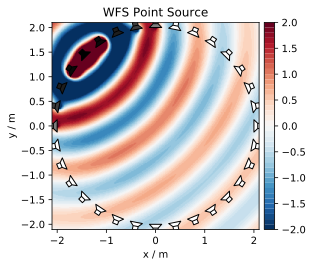

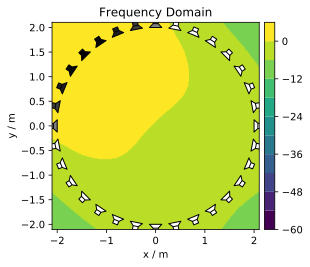

In [5]:
d, sssel, ssfunc = sfs.mono.wfs.point_25d_Unified_WIP(omega, ssd.x, ssd.n, xs)
tapering_window = sfs.tapering.kaiser(sssel, 0)
normalize = 1
plot(As*d*normalize, tapering_window, ssfunc, 'WFS Point Source')

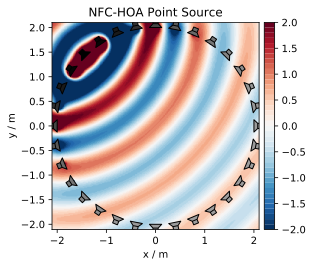

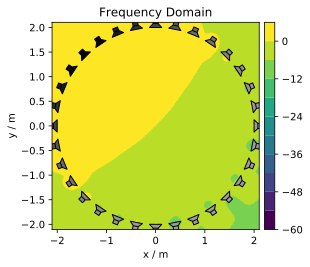

In [6]:
d, sssel, ssfunc = sfs.mono.nfchoa.point_25d(omega, ssd.x, R, xs)
tapering_window = sfs.tapering.kaiser(sssel, 0)
plot(As*d, tapering_window, ssfunc, 'NFC-HOA Point Source')

/Users/fs446/anaconda3/envs/py372/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


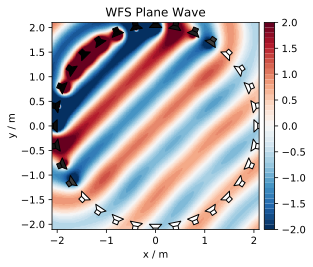

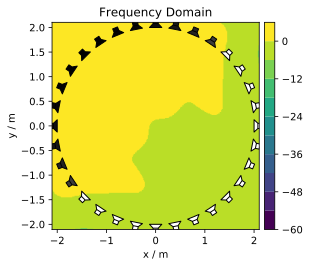

In [7]:
d, sssel, ssfunc = sfs.mono.wfs.plane_25d(omega, ssd.x, ssd.n, npw, xref)
tapering_window = sfs.tapering.kaiser(sssel, 0)
plot(d, tapering_window, ssfunc, 'WFS Plane Wave')

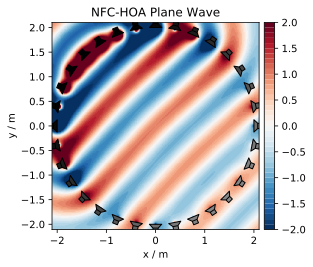

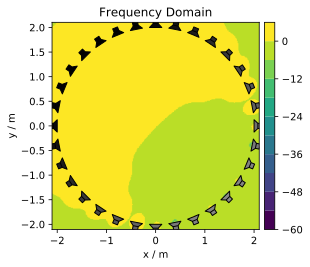

In [8]:
d, sssel, ssfunc = sfs.mono.nfchoa.plane_25d(omega, ssd.x, R, npw)        
tapering_window = sfs.tapering.kaiser(sssel, 0)
plot(d, tapering_window, ssfunc, 'NFC-HOA Plane Wave')

In [9]:
fs = 48000
dirac = unit_impulse(512), fs
dirac = gausspulse(np.arange(0,512)/fs, fc=f, bw=f/10, bwr=-6, tpr=-60, retquad=False, retenv=False), fs

def plot(d, sssel, ss, t=0, ttlstr=''):
    p = sfs.time.synthesize(d, sssel, ssd, ss, grid=grid, observation_time=t)
    vmin = -60
    step = 6
    vmax = 6
    bounds = np.arange(vmin,vmax+step,step)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(4, 4))
    sfs.plot.level(p, grid, vmin=vmin, vmax=vmax, norm=norm, cmap='magma_r')
    sfs.plot.loudspeaker_2d(ssd.x, ssd.n, sssel, size=0.25)
    plt.title('Time Domain, ' + ttlstr)
    plt.grid()        

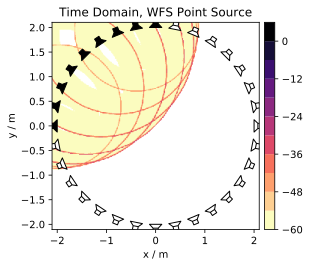

In [10]:
delay, amplitude, sssel, ss = sfs.time.wfs.point_25d(ssd.x, ssd.n, xs)
weird_normalize = 2.5
d = sfs.time.wfs.driving_signals(delay, weird_normalize*amplitude, dirac)
tapering_window = sfs.tapering.kaiser(sssel, 0)
plot(d, tapering_window, ss, t=(ts+0/1000), ttlstr='WFS Point Source')

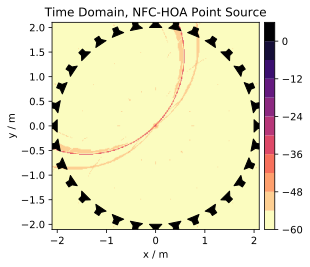

In [11]:
delay, amplitude, sos, phaseshift, sssel, ss = sfs.time.nfchoa.point_25d(ssd.x, R, xs, fs)
d = sfs.time.nfchoa.driving_signals_25d(delay, amplitude, sos, phaseshift, dirac)
tapering_window = sfs.tapering.kaiser(sssel, 0)
plot(d, tapering_window, ss, t=ts, ttlstr='NFC-HOA Point Source')

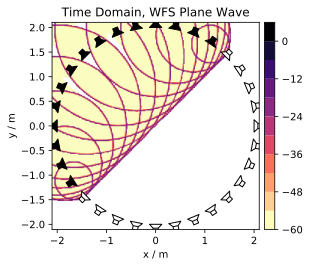

In [12]:
delay, amplitude, sssel, ss = sfs.time.wfs.plane_25d(ssd.x, ssd.n, npw)
tapering_window = sfs.tapering.kaiser(sssel, 0)
d = sfs.time.wfs.driving_signals(delay, amplitude, dirac)
plot(d, tapering_window, ss, t=-0/1000, ttlstr='WFS Plane Wave')

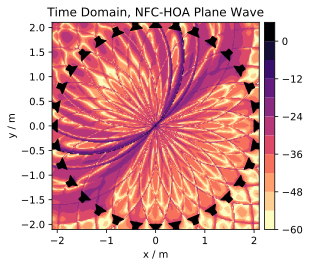

In [13]:
delay, amplitude, sos, phaseshift, sssel, ss = sfs.time.nfchoa.plane_25d(ssd.x, R, npw, fs)
tapering_window = sfs.tapering.kaiser(sssel, 0)
d = sfs.time.nfchoa.driving_signals_25d(delay, amplitude, sos, phaseshift, dirac)
plot(d, tapering_window, ss, t=0/1000, ttlstr='NFC-HOA Plane Wave')